<a href="https://colab.research.google.com/github/emoceanographer/usdanutrients/blob/master/Protein_requirements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import re
import statistics
from operator import add
import numpy as np

import math
import scipy
from scipy import stats
from scipy.optimize import least_squares

import matplotlib.pyplot as plt

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Nutrition/'
pop_path = path + 'WPP2019_PopulationByAgeSex_Medium.csv'
#BMI_path = path + 'NCD_BMI_MEAN.csv'
BMI_path = path + 'NCD_RisC_Lancet_2017_BMI_age_standardised_country.csv'
height_path = path + 'heights_over_time.csv'
fao_ctry_path = path + 'fao_ctry_codes.csv'
CV_path = path + 'Food_Security_Indicators.xlsx'

# Calculate avg. body mass of adults for each country

Population: Dataset is WPP2019, Population by age and sex, medium; for each country; plan is to, for each (country, year), match demographic groups to the age_aa requirement pattern and calculate needed aa requirements

In [0]:
pop_df = pd.read_csv(pop_path, encoding='latin-1') # each country has year, age group's population
BMI_df = pd.read_csv(BMI_path, encoding='latin-1') # each country has a year and an associated mean
height_df = pd.read_csv(height_path)
fao_ctry_codes = pd.read_csv(fao_ctry_path)

In [5]:
fao_ctry_codes

,Short name,Official name,ISO3,ISO2,UNI,UNDP,FAOSTAT,GAUL
0,Afghanistan,the Islamic Republic of Afghanistan,AFG,AF,4,AFG,2,1
1,Albania,the Republic of Albania,ALB,AL,8,ALB,3,3
2,Algeria,the People's Democratic Republic of Algeria,DZA,DZ,12,DZA,4,4
3,Andorra,the Principality of Andorra,AND,AD,20,AND,6,7
4,Angola,the Republic of Angola,AGO,AO,24,AGO,7,8
...,...,...,...,...,...,...,...,...
191,Venezuela (Bolivarian Republic of),the Bolivarian Republic of Venezuela,VEN,VE,862,VEN,236,263
192,Viet Nam,the Socialist Republic of Viet Nam,VNM,VN,704,VNM,237,264
193,Yemen,the Republic of Yemen,YEM,YE,887,YEM,249,269
194,Zambia,the Republic of Zambia,ZMB,ZM,894,ZMB,251,270


In [6]:
pop_df.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
0,4,Afghanistan,2,Medium,1950,1950.5,0-4,0,5,630.044,661.578,1291.622
1,4,Afghanistan,2,Medium,1950,1950.5,5-9,5,5,516.206,487.335,1003.540
2,4,Afghanistan,2,Medium,1950,1950.5,10-14,10,5,461.378,423.326,884.704
3,4,Afghanistan,2,Medium,1950,1950.5,15-19,15,5,414.369,369.363,783.732
4,4,Afghanistan,2,Medium,1950,1950.5,20-24,20,5,374.109,318.392,692.501


In [0]:
def BMI_extract(df,yrs):
  """Gets the average and standard deviation for selected years for male and female BMI"""
  # Male
  temp = df[(df['Sex']=='Men') & (df['Year'].isin(yrs))]
  avgM = temp['Mean BMI'].mean(axis=0)
  #stdM = ((temp['Mean BMI upper 95% uncertainty interval'] - temp['Mean BMI lower 95% uncertainty interval'])/4).mean(axis=0)
  
   # Female
  temp = df[(df['Sex']=='Women') & (df['Year'].isin(yrs))]
  avgF = temp['Mean BMI'].mean(axis=0)
  #stdF = ((temp['Mean BMI upper 95% uncertainty interval'] - temp['Mean BMI lower 95% uncertainty interval'])/4).mean(axis=0)
  
  return avgM, avgF

In [0]:
def perc_calc(percentile, mean_val, std):
  """For a normal distribution, calculate the value of a normal distribution at the nth percentile"""
  x = scipy.special.erfinv(2*percentile-1)*std*2**.5 + mean_val
  return x

In [0]:
# Age group definitions
child_age_grps = ['0-4', '5-9', '10-14', '15-19']
geriatric_age_grps = ['65-69', '70-74', '75-79', '80-84', 
                      '85-89', '90-94', '95-99', '100+']
adult_only_age_grps = ['20-24', '25-29', '30-34', '35-39',
                       '40-44', '45-49', '50-54', '55-59', 
                       '60-64']
adult_age_grps = ['20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74',
       '75-79', '80-84', '85-89', '90-94', '95-99', '100+'] # age groups for pop. data

In [0]:
ctry_mismatches = {'China, Hong Kong SAR': ['none'], 'China, Macao SAR': ['none'], 
                   'China, Taiwan Province of China': ['none'], 
                   "Dem. People's Republic of Korea": "Democratic People's Republic of Korea",
                   'French Guiana': ['none'], 'French Polynesia': ['none'], 
                   'Guadeloupe': ['none'],'Martinique': ['none'],
                   'United Kingdom': ['United Kingdom of Great Britain and Northern Ireland'],
                   'Puerto Rico': ['none'], 'United Republic of Tanzania': 'Tanzania',
                   'Bolivia (Plurinational State of)': 'Bolivia',
                   "Côte d'Ivoire": "Cote d'Ivoire", "Dem. People's Republic of Korea": 'North Korea',
                   'Democratic Republic of the Congo': 'DR Congo', 'Eswatini':'Swaziland',
                   'Iran (Islamic Republic of)':'Iran', 'Republic of Korea': 'South Korea',
                   'Venezuela (Bolivarian Republic of)': 'Venezuela'}

In [10]:
# for each year and country, calculate the average mass of an adult
avg_weight = {}
avg_underweight = {}


for country in list(pop_df.Location.unique()): # cycle through each country
  # population
  temp = pop_df[pop_df['Location'].isin([country])]
  temp = temp[temp['AgeGrp'].isin(adult_age_grps)]
  
  # BMI
  ctr = 0
  if country in BMI_df['Country/Region/World'].unique(): # skip countries for which there is no BMI
    ctr = 1
    BMI = BMI_df[BMI_df['Country/Region/World'] == country]
    
  if country in ctry_mismatches: 
    if ctry_mismatches[country][0] in BMI_df['Country/Region/World'].unique():
      BMI = BMI_df[BMI_df['Country/Region/World'] == ctry_mismatches[country][0]]
      print('mismatch')
      ctr = 1
    if ctry_mismatches[country] == ['none']:
        ctr = 0
  if ctr == 1:

    if country == 'United Kingdom':
      ctry_code = 'GBR'
    else:
      ctry_code = fao_ctry_codes[fao_ctry_codes['Short name'] == country]['ISO3'].values[0]
    
    # Heights (gets people 20-40 in 2011-2013 by year of birth)
    hts = height_df[height_df['Code'] == ctry_code]
    hts_m = hts[(hts['Year']>1970) & (hts['Year']<1994)]['Males (centimeters)'].mean()
    hts_f = hts[(hts['Year']>1970) & (hts['Year']<1994)]['Females (centimeters)'].mean()
    
    f_pop_year = []
    m_pop_year = []
    f_BMI = []
    m_BMI = []
    
    for year in list(pop_df.Time.unique()):
      if year < 2014 and year > 2010: # get 2011-2013
        # population
        f_adult_yr_pop = sum(temp[temp['Time'].isin([year])]['PopFemale'])
        m_adult_yr_pop = sum(temp[temp['Time'].isin([year])]['PopMale'])
        f_pop_year.append(f_adult_yr_pop*1000) # units originally in thousands of people
        m_pop_year.append(m_adult_yr_pop*1000)

        # BMI (average only)
    meanM,meanF = BMI_extract(BMI,[2011,2012,2013])

    f_uw =  (hts_f/100)**2 * 18.5
    m_uw = (hts_m/100)**2 * 18.5
    total_underweight = (f_uw*statistics.mean(f_pop_year) + m_uw*statistics.mean(m_pop_year)) / statistics.mean(list(map(add, f_pop_year, m_pop_year)))
    
    p_muw = BMI[(BMI['Sex']=='Men') & (BMI['Year'].isin([2011,2012,2013]))]['Prevalence of BMI<18.5 kg/m² (underweight)'].values[0].mean()
    p_fuw = BMI[(BMI['Sex']=='Women') & (BMI['Year'].isin([2011,2012,2013]))]['Prevalence of BMI<18.5 kg/m² (underweight)'].values[0].mean()
    
    # Weight calculation (kg)
    f_weight = (hts_f/100)**2 * meanF
    m_weight = (hts_m/100)**2 * meanM
    
    # Population weighting
    avg_weight[country] = (f_weight*statistics.mean(f_pop_year) + m_weight*statistics.mean(m_pop_year)) / statistics.mean(list(map(add, f_pop_year, m_pop_year)))
    avg_underweight[country] = {'weight': total_underweight, 'percent': (p_fuw*statistics.mean(f_pop_year) + p_muw*statistics.mean(m_pop_year)) / statistics.mean(list(map(add, f_pop_year, m_pop_year)))}


  else:
    print(country)

NameError: ignored

## Adding demography but uniform sizes

In [0]:
child_weights = {'0-4': 13, '5-9': 26, '10-14': 46, '15-19': 67} # estimates; https://www.cincinnatichildrens.org/health/g/normal-growth used MF average

In [0]:
temp.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
0,4,Afghanistan,2,Medium,1950,1950.5,0-4,0,5,630.044,661.578,1291.622
1,4,Afghanistan,2,Medium,1950,1950.5,5-9,5,5,516.206,487.335,1003.540
2,4,Afghanistan,2,Medium,1950,1950.5,10-14,10,5,461.378,423.326,884.704
3,4,Afghanistan,2,Medium,1950,1950.5,15-19,15,5,414.369,369.363,783.732
4,4,Afghanistan,2,Medium,1950,1950.5,20-24,20,5,374.109,318.392,692.501


In [0]:
weights = {}
reqs = {'Child': 0.73, 'Adult': 0.66, 'Elderly': 1.2} # FIX THESE
#reqs = {'Child': 0.66, 'Adult': 0.66, 'Elderly': 0.66}

for country in fao_ctry_codes['Short name'].unique(): # cycle through each country
  fao_code = fao_ctry_codes[fao_ctry_codes['Short name']==country]['UNI'].tolist()
  
  # population
  temp = pop_df[pop_df['LocID'].isin(fao_code)]
  
  adult = temp[temp['AgeGrp'].isin(adult_only_age_grps)]
  child = temp[temp['AgeGrp'].isin(adult_only_age_grps)]
  elderly = temp[temp['AgeGrp'].isin(geriatric_age_grps)]

  weights[country] = {}
  yrs = []
  child_yr = []
  adult_yr = []
  eld_yr = []

  for year in list(pop_df.Time.unique()):
    yrs.append(year)
    child_yr.append(sum(child[child['Time'].isin([year])]['PopTotal']*1000)) # units originally in thousands of people
    adult_yr.append(sum(adult[adult['Time'].isin([year])]['PopTotal']*1000))
    eld_yr.append(sum(elderly[elderly['Time'].isin([year])]['PopTotal']*1000))

  # For a constant weight of 62 kg for adults, and 30 kg for children
  weights[country]['child_yr'] = [i*30*reqs['Child'] for i in child_yr]
  weights[country]['adult_yr'] = [i*62*reqs['Adult'] for i in adult_yr]
  weights[country]['eld_yr'] = [i*62*reqs['Elderly'] for i in eld_yr]
  weights[country]['total_yr'] = [i+j+k for i,j,k in zip(weights[country]['child_yr'],weights[country]['adult_yr'] ,weights[country]['eld_yr'])]
  weights[country]['yrs'] = yrs
  
  print(country)


Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia (Plurinational State of)
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo
Cook Islands
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Côte d'Ivoire
Democratic People's Republic of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Faroe Islands
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Latvia
Lebanon
Le

In [0]:
def ctry_plt(country, dict_): 
  child_yr = dict_[country]['child_yr']
  adult_yr = dict_[country]['adult_yr']
  eld_yr = dict_[country]['eld_yr']
  total_yr = dict_[country]['total_yr']
  yrs = dict_[country]['yrs']

  plt.plot(yrs,child_yr, label = 'children')
  plt.plot(yrs,adult_yr, label= 'adults')
  plt.plot(yrs, eld_yr, label = 'elderly')
  plt.plot(yrs, total_yr, label = 'total')
  plt.legend()
  plt.xlabel('Year')
  plt.ylabel('g protein per day total')
  plt.title(country)

In [0]:
# Calculates values for all the entire world (summed)
weights = weights_diff
child_tot = [0 for i in range(0,151)] # 1950:2100
eld_tot = [0 for i in range(0,151)]
adult_tot = [0 for i in range(0,151)]
for ctry in weights:
  child_tot = [i+j for i,j in zip(child_tot, weights[ctry]['child_yr'])]
  eld_tot = [i+j for i,j in zip(eld_tot, weights[ctry]['eld_yr'])]
  adult_tot = [i+j for i,j in zip(adult_tot, weights[ctry]['adult_yr'])]
yrs = weights[ctry]['yrs']
tot_tot = [i+j+k for i,j,k in zip(child_tot,eld_tot,adult_tot)]

weight_tot = {}
weight_tot['all'] = {}
weight_tot['all']['child_yr'] = child_tot
weight_tot['all']['adult_yr'] = adult_tot
weight_tot['all']['eld_yr'] = eld_tot
weight_tot['all']['total_yr'] = tot_tot 
weight_tot['all']['yrs'] = yrs  


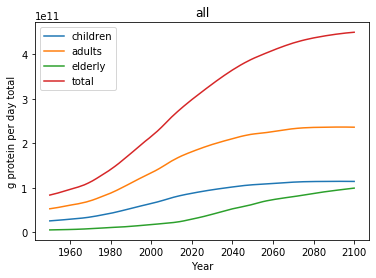

In [0]:
ctry_plt('all',weight_tot)

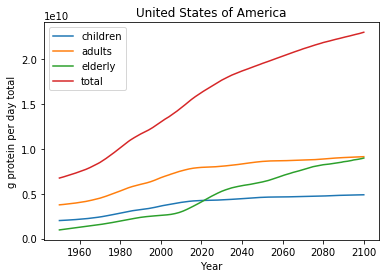

In [0]:
ctry_plt('United States of America', weights)

In [0]:
#this just saved different versions of the
weights_same = weights

In [0]:
weights_diff = weights

In [0]:
sameweight_tot = pd.DataFrame.from_dict(weight_tot['all'])
sameweight_tot[sameweight_tot['yrs'].isin([2100])]

,child_yr,adult_yr,eld_yr,total_yr,yrs
150,1.142001e+11,2.360136e+11,9.915442e+10,4.493681e+11,2100


In [0]:
diffweight_tot = pd.DataFrame.from_dict(weight_tot['all'])
diffweight_tot[diffweight_tot['yrs'].isin([2100])]

In [0]:
## Calculate the total amount of protein needed per age group

def protein_req(age_rng, threshold, size_meas):
  """Calculates the total amount of protein required for an age range,
  using a "safe" or "minimum" threshold, and a "universal", "per country",
  or "over-time" body size measurement"""


In [0]:
# Selects the average UNDERWEIGHT amount (corresponding to BMI of 18.5)
ctry_weights = pd.DataFrame.from_dict(avg_underweight,orient='index')
ctry_weights = ctry_weights.reset_index()
missing = ctry_weights[ctry_weights['weight'].isna()]
list(missing['index'].unique()) # should be just those with actually no data (e.g. Sudan)

[]

## Adding per country body weights

In [0]:
# for each year and country, calculate the average mass of an adult
avg_weight = {}
avg_underweight = {}


for country in list(pop_df.Location.unique()): # cycle through each country
  # population
  temp = pop_df[pop_df['Location'].isin([country])]
  temp = temp[temp['AgeGrp'].isin(adult_age_grps)]
  
  # BMI
  ctr = 0
  if country in BMI_df['Country/Region/World'].unique(): # skip countries for which there is no BMI
    ctr = 1
    BMI = BMI_df[BMI_df['Country/Region/World'] == country]
    
  if country in ctry_mismatches: 
    if ctry_mismatches[country][0] in BMI_df['Country/Region/World'].unique():
      BMI = BMI_df[BMI_df['Country/Region/World'] == ctry_mismatches[country][0]]
      print('mismatch')
      ctr = 1
    if ctry_mismatches[country] == ['none']:
        ctr = 0
  if ctr == 1:

    if country == 'United Kingdom':
      ctry_code = 'GBR'
    else:
      ctry_code = fao_ctry_codes[fao_ctry_codes['Short name'] == country]['ISO3'].values[0]
    
    # Heights (gets people 20-40 in 2011-2013 by year of birth)
    hts = height_df[height_df['Code'] == ctry_code]
    hts_m = hts[(hts['Year']>1970) & (hts['Year']<1994)]['Males (centimeters)'].mean()
    hts_f = hts[(hts['Year']>1970) & (hts['Year']<1994)]['Females (centimeters)'].mean()
    
    f_pop_year = []
    m_pop_year = []
    f_BMI = []
    m_BMI = []
    
    for year in list(pop_df.Time.unique()):
      if year < 2014 and year > 2010: # get 2011-2013
        # population
        f_adult_yr_pop = sum(temp[temp['Time'].isin([year])]['PopFemale'])
        m_adult_yr_pop = sum(temp[temp['Time'].isin([year])]['PopMale'])
        f_pop_year.append(f_adult_yr_pop*1000) # units originally in thousands of people
        m_pop_year.append(m_adult_yr_pop*1000)

        # BMI (average only)
    meanM,meanF = BMI_extract(BMI,[2011,2012,2013])

    f_uw =  (hts_f/100)**2 * 18.5
    m_uw = (hts_m/100)**2 * 18.5
    total_underweight = (f_uw*statistics.mean(f_pop_year) + m_uw*statistics.mean(m_pop_year)) / statistics.mean(list(map(add, f_pop_year, m_pop_year)))
    
    p_muw = BMI[(BMI['Sex']=='Men') & (BMI['Year'].isin([2011,2012,2013]))]['Prevalence of BMI<18.5 kg/m² (underweight)'].values[0].mean()
    p_fuw = BMI[(BMI['Sex']=='Women') & (BMI['Year'].isin([2011,2012,2013]))]['Prevalence of BMI<18.5 kg/m² (underweight)'].values[0].mean()
    
    # Weight calculation (kg)
    f_weight = (hts_f/100)**2 * meanF
    m_weight = (hts_m/100)**2 * meanM
    
    # Population weighting
    avg_weight[country] = (f_weight*statistics.mean(f_pop_year) + m_weight*statistics.mean(m_pop_year)) / statistics.mean(list(map(add, f_pop_year, m_pop_year)))
    avg_underweight[country] = {'weight': total_underweight, 'percent': (p_fuw*statistics.mean(f_pop_year) + p_muw*statistics.mean(m_pop_year)) / statistics.mean(list(map(add, f_pop_year, m_pop_year)))}


  else:
    print(country)

# Calculate AA requirements per capita (adults)

In [0]:
case = 'safe'

if case == 'baseline':

  AA_adult_req = {'Histidine': 15, 'Isoleucine': 30, 'Leucine': 59, 'Lysine': 45, 
                 'SAA': 22, 'AAA': 38, 'Threonine': 23, 'Tryptophan': 6, 'Valine': 39} # mg AA /g protein
  AA_total = .66 # g/kg
elif case == 'safe':
  AA_adult_req = {'Histidine': 12, 'Isoleucine': 24, 'Leucine': 47, 'Lysine': 36, 
                 'SAA': 17, 'AAA': 30, 'Threonine': 18, 'Tryptophan': 5, 'Valine': 31} # mg AA /g protein
  AA_total = .83 # g/kg

In [0]:
SAA = ['Methionine', 'Cystine'] # there are others, but not in my diet AA list
AAA = ['Phenylalanine', 'Tyrosine'] # also tryptophan and histidine but they are listed separately

In [0]:
# NOT EAT-Lancet
#diet_AA = pd.read_csv(path + 'diet_aa_1126_waste.csv')
diet_AA = pd.read_csv(path + 'diet_aa_current_withsubs.csv')

In [0]:
# EAT-Lancet
#diet_AA = pd.read_csv(path + 'diet_aa_eat_lancet.csv')
diet_AA = pd.read_csv(path + 'diet_aa_eatlancet_withsubs.csv')


In [0]:
diet_AA.head()

,Unnamed: 0,Tryptophan,Threonine,Isoleucine,Leucine,Lysine,Methionine,Cystine,Phenylalanine,Tyrosine,Valine,Arginine,Histidine,Alanine,Aspartic,Glutamic,Glycine,Serine,protein
0,all-r,0.824814,2.840416,3.234060,5.706459,5.365887,1.757487,0.881298,3.364310,2.388827,3.590507,4.954875,1.996653,1.605689,3.719884,8.187701,1.301508,1.690849,75.917363
1,HIC,1.058391,3.721594,4.193758,7.345268,7.145583,2.321522,1.129461,4.273194,3.082853,4.621841,6.112248,2.591660,1.751056,3.977686,9.538550,1.453121,1.933711,98.935805
2,UMC,1.021823,3.613558,4.079480,7.189858,6.921440,2.260763,1.096816,4.169556,3.012290,4.505865,5.944016,2.514458,1.717137,3.882230,9.173498,1.378224,1.876460,95.894633
3,LMC,0.784040,2.685262,3.066537,5.402547,5.050060,1.658910,0.837089,3.205867,2.257867,3.411042,4.765309,1.886771,1.576281,3.696006,7.966629,1.279784,1.644435,71.857102
4,LIC,0.556809,1.803345,2.097855,3.796391,3.287390,1.082998,0.594064,2.283287,1.595831,2.361480,3.559109,1.320599,1.464568,3.403934,6.767233,1.156944,1.451411,49.139684


In [0]:
names = {'Cape Verde': 'Cabo Verde', 'Czech Republic': 'Czechia', 
         'C√¥te d&#39;Ivoire': "Côte d'Ivoire", 'Côte d&#39;Ivoire': "Côte d'Ivoire",
         'Democratic People&#39;s Republic of Korea':
        "Democratic People's Republic of Korea", 
         'Faroe Islands (Associate Member)': 'Faroe Islands', 
         'Lao People&#39;s Democratic Republic': "Lao People's Democratic Republic",
          'Swaziland': 'Eswatini', 'Tokelau (Associate Member)': 'Tokelau',
        'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland'}
ignore = ['Holy See','Liechtenstein','The former Yugoslav Republic of Macedonia',
          np.nan,'Antarctica']

In [0]:
def name2iso3(name, names, ctry_codes):
  if name in names:
    iso3 = ctry_codes[ctry_codes['Short name'] == names[name]]['ISO3'].values[0]
  elif name in ignore:
    iso3 = np.nan
  else:
    iso3 = ctry_codes[ctry_codes['Short name'] == name]['ISO3'].values[0]
  return iso3

In [0]:
isos = []
for country in ctry_weights['index'].unique(): # assigns ISO3 values to country names
  isos.append(name2iso3(country,names,fao_ctry_codes))
ctry_weights['ISO3'] = isos

In [0]:
# EAT-Lancet version
AA_ctry = {}
AA_all = {}
for country in diet_AA['Unnamed: 0'].unique().tolist():
  if country in ctry_weights['ISO3'].unique().tolist():
    diet_ctry = diet_AA[diet_AA['Unnamed: 0'] == country]
    AA_ctry[country] = {}
    AA_all[country] = {}
    for AA in AA_adult_req: 
      avg_weight = ctry_weights[ctry_weights['ISO3']==country]['weight'].values[0] 
      AA_req =  avg_weight * AA_total * AA_adult_req[AA] * 0.001 #g/capita/day
      if AA == 'SAA':
        aa_diet = []
        for aa in SAA: 
          aa_diet.append(diet_ctry[aa].values[0])
        AA_diet = sum(aa_diet)
      elif AA == 'AAA':
        aa_diet = []
        for aa in AAA: 
          aa_diet.append(diet_ctry[aa].values[0])
        AA_diet = sum(aa_diet)
      else:
        AA_diet = diet_ctry[AA].values[0]
      AA_ctry[country][AA] = AA_diet / AA_req #[AA_req, AA_diet, AA_diet/AA_req] 
      AA_all[country][AA] = [AA_req, AA_diet, AA_diet/AA_req] 
      if AA_ctry[country][AA]<1:
        print(country, ' lacking ' , AA, ' see: ', AA_req, AA_diet)
    total_protein_req = avg_weight * AA_total
    total_protein_diet = diet_ctry['protein'].values[0]
    AA_ctry[country]['protein'] =  total_protein_diet/total_protein_req #[total_protein_req, total_protein_diet, total_protein_diet/total_protein_req]
    AA_all[country]['protein'] = [total_protein_req, total_protein_diet, total_protein_diet/total_protein_req]
    if AA_ctry[country]['protein'] < 1: 
      print(country, ' lacking total protein, see' , total_protein_req, total_protein_diet)

BDI  lacking total protein, see 40.22304740634166 35.656407523164575
CAF  lacking total protein, see 41.17876392106861 38.27858393090995
ERI  lacking total protein, see 41.031221395992034 39.23842512434006
GIN  lacking total protein, see 41.28102389063809 37.68277423774101
MWI  lacking total protein, see 39.26671319363268 37.995569312015455
RWA  lacking total protein, see 39.775335029288 34.50022620367821
TCD  lacking total protein, see 42.93093663498566 41.520137219134185
GNQ  lacking total protein, see 41.73330701861095 28.25461021734612


In [0]:
AA_ctry = {}
AA_all = {}
for country in diet_AA['Unnamed: 0'].unique().tolist():
  if country in ctry_weights['index'].unique().tolist():
    diet_ctry = diet_AA[diet_AA['Unnamed: 0'] == country]
    AA_ctry[country] = {}
    AA_all[country] = {}
    for AA in AA_adult_req: 
      avg_weight = ctry_weights[ctry_weights['index']==country]['weight'].values[0] 
      AA_req =  avg_weight * AA_total * AA_adult_req[AA] * 0.001 #g/capita/day
      if AA == 'SAA':
        aa_diet = []
        for aa in SAA: 
          aa_diet.append(diet_ctry[aa].values[0])
        AA_diet = sum(aa_diet)
      elif AA == 'AAA':
        aa_diet = []
        for aa in AAA: 
          aa_diet.append(diet_ctry[aa].values[0])
        AA_diet = sum(aa_diet)
      else:
        AA_diet = diet_ctry[AA].values[0]
      AA_ctry[country][AA] = AA_diet / AA_req #[AA_req, AA_diet, AA_diet/AA_req] 
      AA_all[country][AA] = [AA_req, AA_diet, AA_diet/AA_req] 
      if AA_ctry[country][AA]<1:
        print(country, ' lacking ' , AA, ' see: ', AA_req, AA_diet)
    total_protein_req = avg_weight * AA_total
    total_protein_diet = diet_ctry['protein'].values[0]
    AA_ctry[country]['protein'] =  total_protein_diet/total_protein_req #[total_protein_req, total_protein_diet, total_protein_diet/total_protein_req]
    AA_all[country]['protein'] = [total_protein_req, total_protein_diet, total_protein_diet/total_protein_req]
    if AA_ctry[country]['protein'] < 1: 
      print(country, ' lacking total protein, see' , total_protein_req, total_protein_diet)

NameError: ignored

In [0]:
AA_ratios = pd.DataFrame.from_dict(AA_ctry,orient='index')

In [0]:
savepath = path + 'AA_ratios_EATLanceteven_safe_withsubs.csv'
AA_ratios.to_csv(savepath)

## Undernourishment
Use the average diet as the mean of lognormal & the avg. requirement as threshold for undernourishment (NB FAO would use a 5th percentile for this?)

In [0]:
CVs = pd.read_excel(CV_path,sheet_name='A_6',header=2)

In [0]:
CVs.head()

,FAOST_CODE,Regions/Subregions/Countries,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,5001,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5852,Developing countries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5100,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,421,Northern Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Algeria,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.27,0.27,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28


In [0]:
def prop_under(s_mean, CV, x):
  sigma = ((math.log(CV**2+1)))**0.5
  mu = math.log(s_mean) - sigma**2/2
  CDF = 1/2 + 1/2*scipy.special.erf((math.log(x) - mu)/(2**0.5*sigma))
  return CDF

In [0]:
def CV_calc(df,years):
  """Expects dataframe for a country and will extract coefficient of variation
  for the selected years"""
  vals = df[years].values[0]
  mean_val = statistics.mean(vals)
  if np.isnan(mean_val):
    mean_val = 0.2 # conservative coefficient of variation if no data
  return mean_val

In [0]:
# calculates the proportion under each
variable_diet = {}
for country in AA_all:
  variable_diet[country] = {}
  ctry_CV = CVs[CVs['Regions/Subregions/Countries']==country]
  CV = CV_calc(ctry_CV,[2011,2012,2013])
  #print([country,CV])
  for AA in AA_all[country]:
    pr_mean = AA_all[country][AA][1] # average amount in diet
    req = AA_all[country][AA][0] # average requirement

    CDF = prop_under(pr_mean, CV, req)
    variable_diet[country][AA] = CDF

IndexError: ignored

In [0]:
CVs.head()

,FAOST_CODE,Regions/Subregions/Countries,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,5001,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5852,Developing countries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5100,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,421,Northern Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Algeria,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.27,0.27,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28


In [0]:
fao_ctry_codes.head()

,Short name,Official name,ISO3,ISO2,UNI,UNDP,FAOSTAT,GAUL
0,Afghanistan,the Islamic Republic of Afghanistan,AFG,AF,4,AFG,2,1
1,Albania,the Republic of Albania,ALB,AL,8,ALB,3,3
2,Algeria,the People's Democratic Republic of Algeria,DZA,DZ,12,DZA,4,4
3,Andorra,the Principality of Andorra,AND,AD,20,AND,6,7
4,Angola,the Republic of Angola,AGO,AO,24,AGO,7,8


In [0]:
def fao2iso3(code, fao_ctry_codes):
  """Gets iso3 from fao code"""
  if code in fao_ctry_codes['FAOSTAT'].unique():
    iso3 = list(fao_ctry_codes[fao_ctry_codes['FAOSTAT']==code]['ISO3'])[0]
  else:
    iso3 = np.nan
  return iso3

In [0]:
isos = []
for faocode in CVs['FAOST_CODE'].unique():
  isos.append(fao2iso3(faocode,fao_ctry_codes))
CVs['ISO3'] = isos

In [0]:
# EAT-Lancet version; calculates the proportion under each
variable_diet = {}
for country in AA_all:
  variable_diet[country] = {}
  ctry_CV = CVs[CVs['ISO3']==country]
  CV = CV_calc(ctry_CV,[2011,2012,2013])
  #print([country,CV])
  for AA in AA_all[country]:
    pr_mean = AA_all[country][AA][1] # average amount in diet
    req = AA_all[country][AA][0] # average requirement

    CDF = prop_under(pr_mean, CV, req)
    variable_diet[country][AA] = CDF


In [0]:
variable_diet_df = pd.DataFrame.from_dict(variable_diet,orient='index')
variable_diet_df.head()

,Histidine,Isoleucine,Leucine,Lysine,SAA,AAA,Threonine,Tryptophan,Valine,protein
AFG,1.280379e-05,6.426930e-04,2.103820e-03,5.144144e-04,9.934244e-05,5.991797e-07,1.081512e-04,6.092600e-06,3.812835e-03,0.130227
AGO,1.226930e-06,6.987344e-05,3.043057e-04,5.470536e-06,6.262490e-06,3.016896e-07,4.753786e-06,2.654779e-06,6.709270e-04,0.030692
ALB,3.275158e-15,7.556844e-12,2.795377e-10,3.679834e-13,2.314815e-14,0.000000e+00,2.997602e-14,2.775558e-15,1.026152e-09,0.000022
ARG,1.998401e-15,4.258816e-12,1.394005e-10,1.055822e-13,1.409983e-14,0.000000e+00,1.532108e-14,3.053113e-15,5.747448e-10,0.000011
ARM,1.056731e-09,1.151641e-07,1.094930e-06,2.941633e-08,3.838448e-09,1.096156e-11,4.300098e-09,6.461424e-10,2.420744e-06,0.001540


In [0]:
savepath = path + 'undernourished_CVs_EL_1218.csv'
variable_diet_df.to_csv(savepath)

# Old Code

In [0]:
# BMI regex work! (save me for now!)
temp = BMI['2016'].values[0]
print(temp)
m = re.search(r"[^[]*\[([^]]*)\]", temp).groups()[0] # gets the things in the brackets!
n = re.search(r'^.*(?=(\[))', temp).group(0)
print(m)
print(n)

23.4 [22.0-24.8]
22.0-24.8
23.4 


In [0]:
adult_weight = 136.68 # average adult weight


In [0]:
# calculate average height (m) for each country; look into this later
ctry_hts = {}
for country in list(pop_df.Location.unique()): 
  if country in list(height_df.Entity.unique()):
    ht = height_df[height_df['Entity'].isin([country])]
    m_ht = statistics.mean(ht['Males (centimeters)'])
    f_ht = statistics.mean(ht['Females (centimeters)'])
    ctry_hts[country] = {'M': m_ht/100, 'F': f_ht/100}

In [0]:
# match those historical populations with average weight
avg_adult_weight = {}
total_adult_weight = {}

for country in list(pop_df.Location.unique()): 
  BMI = BMI_df[BMI_df['Country'].isin([country])]
  f_yrs_weight = {}
  m_yrs_weight = {}
  
  ctry_ht = ctry_hts.get(country)
  if ctry_ht:
    m_ht = ctry_ht['M'] # get the average height for that country
    f_ht = ctry_ht['F']

    f_tot_weight = {} # pre-allocate
    m_tot_weight = {}
    tot_yr_weight = {}
    for year in list(pop_df.Time.unique()):
      # BMI
      if str(year) in BMI.columns: # only go through years for which we have data
        avg_m_BMI = re.sub(r'\[[^]]*\]','',BMI[str(year)+'.1'].item())
        avg_f_BMI = re.sub(r'\[[^]]*\]','',BMI[str(year)+'.2'].item())
        
        f_yrs_weight[year] = float(avg_f_BMI)*(f_ht)**2 # calculates weight from BMI and height
        m_yrs_weight[year] = float(avg_m_BMI)*(m_ht)**2
        
        f_tot_weight[year] = f_adult_population[country][year]*f_yrs_weight[year]
        m_tot_weight[year] = m_adult_population[country][year]*m_yrs_weight[year]
        tot_yr_weight[year] = f_tot_weight[year] + m_tot_weight[year]
        
    avg_adult_weight[country] = {'f': f_yrs_weight, 'm': m_yrs_weight}
  
    total_adult_weight[country] = tot_yr_weight
  else:
    print([country, ' did not have associated height'])

['Africa', ' did not have associated height']
['Aruba', ' did not have associated height']
['Asia', ' did not have associated height']
['Australia/New Zealand', ' did not have associated height']
['Bolivia (Plurinational State of)', ' did not have associated height']
['Brunei Darussalam', ' did not have associated height']
['Cabo Verde', ' did not have associated height']
['Caribbean', ' did not have associated height']
['Central America', ' did not have associated height']
['Central and Southern Asia', ' did not have associated height']
['Central Asia', ' did not have associated height']
['Channel Islands', ' did not have associated height']
['China, Hong Kong SAR', ' did not have associated height']
['China, Macao SAR', ' did not have associated height']
['China, Taiwan Province of China', ' did not have associated height']
["Côte d'Ivoire", ' did not have associated height']
['Curaçao', ' did not have associated height']
['Czechia', ' did not have associated height']
["Dem. People's

ValueError: ignored